In [49]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings; warnings.filterwarnings(action='once')

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')

%matplotlib inline

## Objectives:
- Develop the best strategy to book Airb&b rooms in Boston
    - Find the cheapest/most expensive listings in the same area (zipcode) at similar rating levels

## Load in Data

In [3]:
lst_df = pd.read_csv('data/santaclara/listings.csv.gz')
cal_df = pd.read_csv('data/santaclara/calendar.csv.gz')
rev_df = pd.read_csv('data/santaclara/reviews.csv.gz')

### Take a quick look at the data

In [4]:
display(lst_df.shape, cal_df.shape, rev_df.shape)

(7658, 106)

(2795182, 7)

(221803, 6)

In [5]:
lst_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,4952,https://www.airbnb.com/rooms/4952,20191107231003,2019-11-07,Butterfly Inn - Graceful Living !,Lovely garden setting in a serene and art-fill...,Very comfortable Queen bed and small desk in b...,Lovely garden setting in a serene and art-fill...,none,"Located in Professorville, Palo Alto, one of t...",...,f,f,moderate,f,f,5,0,5,0,0.60
1,11464,https://www.airbnb.com/rooms/11464,20191107231003,2019-11-08,Deluxe Private Studio-custom int.,Custom built Studio with exquisite design. Per...,Description A favorite for international corpo...,Custom built Studio with exquisite design. Per...,none,10 min. to Lucky's and Starbucks at El Camino ...,...,t,f,moderate,f,t,15,15,0,0,0.09
2,19181,https://www.airbnb.com/rooms/19181,20191107231003,2019-11-08,Majestic Room #1 with Sauna and Large Family Room,Enjoy your privacy in this spacious and luxuri...,This is a lock-off guest unit in the lower lev...,Enjoy your privacy in this spacious and luxuri...,none,We are located in a 5-minute walk to downtown ...,...,f,f,moderate,t,t,3,1,2,0,0.11
3,21373,https://www.airbnb.com/rooms/21373,20191107231003,2019-11-07,Bonsai Garden Inn in Professorville,Room in gracious home with beautiful garden. ...,"Bright, garden-facing room in beautiful home. ...",Room in gracious home with beautiful garden. ...,none,This room is in an ultra convenient location i...,...,f,f,moderate,f,f,5,0,5,0,2.16
4,23732,https://www.airbnb.com/rooms/23732,20191107231003,2019-11-07,Heart of Silicon Valley bdrm & bath,NaN,You'll have the room to yourself as well as a ...,You'll have the room to yourself as well as a ...,none,NaN,...,f,f,moderate,f,f,1,0,1,0,0.03


In [6]:
cal_df.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,4952,2019-11-07,f,$75.00,$75.00,2.0,365.0
1,4952,2019-11-08,f,$75.00,$75.00,2.0,365.0
2,4952,2019-11-09,f,$75.00,$75.00,2.0,365.0
3,4952,2019-11-10,f,$75.00,$75.00,2.0,365.0
4,4952,2019-11-11,f,$75.00,$75.00,2.0,365.0


In [7]:
rev_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,4952,6560,2009-08-02,25672,Diane,Staying with Mei Lin and Ross at the Butterfly...
1,4952,8953,2009-09-04,27901,Michaela,I stayed with Mei Lin and Ross during a confer...
2,4952,13779,2009-10-16,33939,Mark,What a wonderful place to stay. Wonderful peop...
3,4952,19790,2009-12-10,55537,David,"Convenient & easy-going, which is what I needed."
4,4952,51096,2010-06-08,131240,SiNae,"Warm and friendly folks, very helpful! Very co..."


44 out of the 95 columns in the `listing` table have NAN values

In [8]:
(lst_df.isna().mean() > 0).value_counts()

True     54
False    52
dtype: int64

In [40]:
# Columns with the most missing values

lst_df.isna().mean().sort_values(ascending = False).tail(50)

experiences_offered                             0.0
host_verifications                              0.0
street                                          0.0
neighbourhood_cleansed                          0.0
last_scraped                                    0.0
scrape_id                                       0.0
listing_url                                     0.0
host_url                                        0.0
accommodates                                    0.0
smart_location                                  0.0
calendar_updated                                0.0
availability_30                                 0.0
availability_60                                 0.0
availability_90                                 0.0
availability_365                                0.0
calendar_last_scraped                           0.0
number_of_reviews                               0.0
number_of_reviews_ltm                           0.0
requires_license                                0.0
instant_book

In [11]:
# Columns contain keywords "review"

lst_df.filter(like='score', axis=1).isna().mean()

review_scores_rating           0.186994
review_scores_accuracy         0.187125
review_scores_cleanliness      0.187125
review_scores_checkin          0.187386
review_scores_communication    0.187255
review_scores_location         0.187255
review_scores_value            0.187386
dtype: float64

In [12]:
lst_df.select_dtypes(exclude = 'object').columns

Index(['id', 'scrape_id', 'thumbnail_url', 'medium_url', 'xl_picture_url',
       'host_id', 'host_acceptance_rate', 'host_listings_count',
       'host_total_listings_count', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'square_feet', 'guests_included', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'license',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'c

In [14]:
lst_df['id'].is_unique

True

In [13]:
lst_df.select_dtypes(include = 'object').columns

Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'access', 'interaction', 'house_rules', 'picture_url',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed', 'city', 'state',
       'zipcode', 'market', 'smart_location', 'country_code', 'country',
       'is_location_exact', 'property_type', 'room_type', 'bed_type',
       'amenities', 'price', 'weekly_price', 'monthly_price',
       'security_deposit', 'cleaning_fee', 'extra_people', 'calendar_updated',
       'has_availability', 'calendar_last_scraped', 'first_review',
       'last_review', 'requires_license', 'jurisdictio

In [24]:

lst_df.groupby(['zipcode']).count()['id']

zipcode
94022        91
94024        56
94025         6
94028         1
94040       231
           ... 
CA 94041      3
CA 94089      3
CA 95126      5
CA 95128      1
CA 95134      1
Name: id, Length: 72, dtype: int64

In [44]:
# clean up zipcode column data (i.e. CA 94041 ---> 94041)
lst_df['zipcode'] = lst_df['zipcode'].str.extract(pat = '(9+[0-9]{4})')

lst_df.groupby('zipcode')['id'].count()

zipcode
94022     91
94024     56
94025      6
94028      1
94040    233
        ... 
95138     16
95139     13
95140      3
95148     68
95215      1
Name: id, Length: 64, dtype: int64

In [15]:
# cut the review_scores_rating into 10 bins
bins = list(range(0,110,10))
lst_df['ratings']=pd.cut(lst_df['review_scores_rating'],bins)


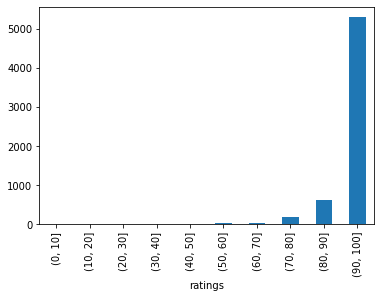

In [16]:
# How many listings fall under each rating
lst_df.groupby('ratings').count()['id'].plot(kind = 'bar')

### Is higher rated listing more expensive?

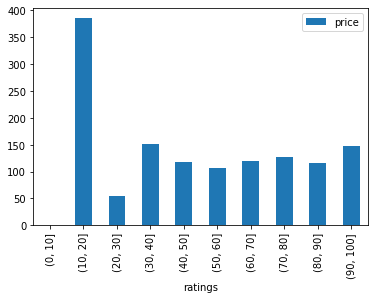

In [17]:
# convert price column data type from object to float
lst_df['price'] = lst_df['price'].replace('[\$,]', '', regex=True).astype(float)

# plot average listing price against review scores
lst_df.groupby('ratings')[['price']].mean().plot(kind = 'bar')


### How does host response time impact customer satisfaction?

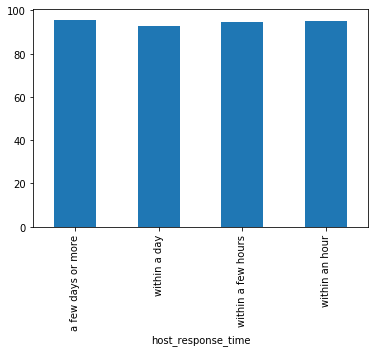

In [18]:
lst_df.groupby('host_response_time').mean()['review_scores_rating'].plot.bar()

### Most expensive zipcode

In [19]:
lst_df.groupby(['zipcode'])['price'].agg(['mean','count']).sort_values('mean', ascending = False)

,mean,count
zipcode,,
95030,505.750000,60
94028,500.000000,1
95009,500.000000,1
95138,440.937500,16
94115,329.000000,1
...,...,...
95130,82.729167,48
95215,80.000000,1
95122,74.400000,95


### Does super host's room command a premium

In [20]:
lst_df.groupby(['host_is_superhost'])['review_scores_rating'].agg(['mean','count']).sort_values('mean', ascending = False)

,mean,count
host_is_superhost,,
t,97.410307,3066
f,92.883544,3160


In [21]:
lst_df.groupby(['host_is_superhost'])['price'].agg(['mean','count']).sort_values('mean', ascending = False)

,mean,count
host_is_superhost,,
f,173.236861,4205
t,145.531866,3452
